# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [53]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [99]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 3        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [79]:
# train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None, load=False)


Better to keep validation and testing set in RAM, but not always possible

In [100]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=1, nfile=None)

In [101]:
val_nonrot_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, experiment='deepsphere_norot', augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [102]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=augmentation, nfile=None)

In [10]:
#dataset = train_TFDataset.get_tf_dataset(32)

In [11]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [103]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 94092


In [13]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [15]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [104]:
#EXP_NAME = 'shrec17_Graph_Cohen_4K_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
EXP_NAME = 'shrec17_newBestGraphFull_best_4K_triplet_norot_{}aug_{}sides{}'.format(augmentation, Nside, ename)
#EXP_NAME = 'essai_0loss'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [106]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
params["std"] = [0.002, 0.009, 0.025, 0.09, 0.15, 0.5]
params["full"] = [True]*6
params["extra_loss"]=True
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 57,810,124,800
Learning rate will start at 2.0e-02 and finish at 2.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 6 * 16 * 4 = 384
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
   

In [21]:
#EXP_NAME = "shrec17_best_4K_cache_1aug_128sides_CNN"
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [107]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 189,040


In [ ]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 735 / 147018 (epoch 0.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 81.25, training loss = 1.43e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 72.12 (3702 / 5133), f1 (weighted): 69.39, loss: 1.71e+00
  CPU time: 207s, wall time: 156s, perf_time_load: 0.17s, perf_time: 0.00s
step 1470 / 147018 (epoch 0.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 78.12, training loss = 1.25e+00
  validation accuracy: 76.76 (3940 / 5133), f1 (weighted): 75.25, loss: 1.35e+00
  CPU time: 407s, wall time: 307s, perf_time_load: 0.15s, perf_time: 0.00s
step 2205 / 147018 (epoch 0.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 81.25, training loss = 8.53e-01
  validation accuracy: 80.26 (4120 / 5133), f1 (weighted): 78.59, loss: 1.17e+00
  CPU time: 613s, wall time: 458s, perf_time_load: 0.15s, perf_time: 0.00s
step 2940 / 147018 (epoch 1.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 78.12, training loss = 1.16e+00
  validation accuracy: 80.09 (4111 / 5133), f1 (weighted): 78.84, loss: 1.14e+00
  CPU time: 798s, wall time: 609s, perf_time_load: 0.17s, perf_time: 0.00s
step 3675 / 147018 (ep

  validation accuracy: 84.28 (4326 / 5133), f1 (weighted): 83.91, loss: 9.15e-01
  CPU time: 5902s, wall time: 4559s, perf_time_load: 0.20s, perf_time: 0.00s
step 23520 / 147018 (epoch 8.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 3.79e-01
  validation accuracy: 83.69 (4296 / 5133), f1 (weighted): 83.28, loss: 9.10e-01
  CPU time: 6084s, wall time: 4703s, perf_time_load: 0.17s, perf_time: 0.00s
step 24255 / 147018 (epoch 8.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 90.62, training loss = 2.63e-01
  validation accuracy: 83.97 (4310 / 5133), f1 (weighted): 83.75, loss: 9.07e-01
  CPU time: 6263s, wall time: 4846s, perf_time_load: 0.18s, perf_time: 0.00s
step 24990 / 147018 (epoch 8.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 2.93e-01
  validation accuracy: 82.82 (4251 / 5133), f1 (weighted): 82.46, loss: 9.43e-01
  CPU time: 6444s, wall time: 4992s, perf_time_load: 0.15s, perf_time: 0.00s
step 25725 

step 44835 / 147018 (epoch 15.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.54e-01
  validation accuracy: 83.73 (4298 / 5133), f1 (weighted): 83.55, loss: 9.70e-01
  CPU time: 11393s, wall time: 8730s, perf_time_load: 0.15s, perf_time: 0.00s
step 45570 / 147018 (epoch 15.50 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 6.00e-02
  validation accuracy: 84.16 (4320 / 5133), f1 (weighted): 83.77, loss: 9.58e-01
  CPU time: 11577s, wall time: 8866s, perf_time_load: 0.16s, perf_time: 0.00s
step 46305 / 147018 (epoch 15.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 6.47e-02
  validation accuracy: 84.67 (4346 / 5133), f1 (weighted): 84.34, loss: 9.31e-01
  CPU time: 11760s, wall time: 9006s, perf_time_load: 0.18s, perf_time: 0.00s
step 47040 / 147018 (epoch 16.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.77e-01
  validation accuracy: 84.28 (4326 / 51

  validation accuracy: 84.02 (4313 / 5133), f1 (weighted): 83.76, loss: 1.03e+00
  CPU time: 16589s, wall time: 12695s, perf_time_load: 0.16s, perf_time: 0.00s
step 66885 / 147018 (epoch 22.75 / 50):
  learning_rate = 2.00e-02, training accuracy = 100.00, training loss = 1.45e-01
  validation accuracy: 84.08 (4316 / 5133), f1 (weighted): 83.78, loss: 1.00e+00
  CPU time: 16775s, wall time: 12833s, perf_time_load: 0.15s, perf_time: 0.00s
step 67620 / 147018 (epoch 23.00 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 3.60e-01
  validation accuracy: 84.26 (4325 / 5133), f1 (weighted): 84.13, loss: 9.76e-01
  CPU time: 16956s, wall time: 12970s, perf_time_load: 0.15s, perf_time: 0.00s
step 68355 / 147018 (epoch 23.25 / 50):
  learning_rate = 2.00e-02, training accuracy = 96.88, training loss = 2.73e-01
  validation accuracy: 84.41 (4333 / 5133), f1 (weighted): 84.19, loss: 9.90e-01
  CPU time: 17142s, wall time: 13106s, perf_time_load: 0.16s, perf_time: 0.00s

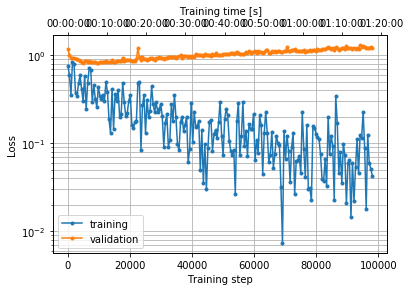

In [30]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [16]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


('accuracy: 96.53 (30277 / 31364), f1 (weighted): 96.54, loss: 1.16e-01\nCPU time: 275s, wall time: 257s',
 96.53424308123964,
 96.54157073077505,
 0.115866209483545)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [98]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN/model-294037


('accuracy: 84.24 (12972 / 15399), f1 (weighted): 83.93, loss: 1.09e+00\nCPU time: 52s, wall time: 61s',
 84.23923631404637,
 83.92844681653466,
 1.0901064912877085)

In [86]:
model.evaluate(val_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN/model-294037


('accuracy: 84.53 (4339 / 5133), f1 (weighted): 84.18, loss: 1.08e+00\nCPU time: 14s, wall time: 18s',
 84.5314630820183,
 84.18278247800087,
 1.0770438693546538)

In [55]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


In [87]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN/model-294037


In [88]:
ids_val = val_dataset.get_ids()

In [20]:
#predictions = predictions.astype(np.int)

In [21]:
from SHREC17.load_shrec import shrec_output

In [56]:
shrec_output(model.get_descriptor(val_dataset), ids_val, probabilities, datapath, 'results/val_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


In [89]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [62]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


0it [00:00, ?it/s]
79it [00:00, 778.06it/s]
153it [00:00, 758.42it/s]
245it [00:00, 809.64it/s]
337it [00:00, 836.38it/s]
408it [00:00, 811.22it/s]
499it [00:00, 827.17it/s]
591it [00:00, 840.17it/s]
683it [00:00, 849.59it/s]
775it [00:00, 855.37it/s]
864it [00:01, 857.92it/s]
955it [00:01, 860.50it/s]Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

10265it [00:10, 958.56it/s]


In [90]:
test_nonrot_dataset = Shrec17DatasetCache(datapath, 'test', perturbed=noise_dataset, download=download, 
                                          nside=Nside, experiment='deepsphere_norot', augmentation=augmentation, nfile=None)

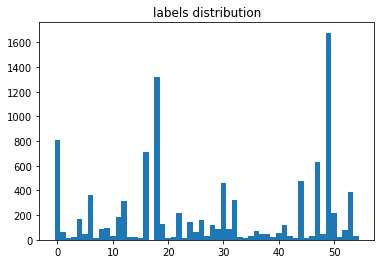

In [63]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [77]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraph_best_4K_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraph_best_4K_6feat_1aug_32sides_CNN/model-26950


('accuracy: 77.80 (7986 / 10265), f1 (weighted): 77.98, loss: 1.17e+00\nCPU time: 15s, wall time: 15s',
 77.79834388699464,
 77.97818766736253,
 1.1658846674346366)

In [91]:
model.evaluate(test_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN/model-294037


('accuracy: 80.42 (8255 / 10265), f1 (weighted): 80.65, loss: 1.40e+00\nCPU time: 27s, wall time: 35s',
 80.4188991719435,
 80.65244263465385,
 1.4044862921390078)

In [ ]:
#predictions = model.predict(x_test)

In [57]:
probabilities = model.probs(x_test, nclass)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


In [92]:
probabilities, _ = model.probs(test_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_all_3aug_32sides_CNN/model-294037


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [ ]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [64]:
shrec_output(model.get_descriptor(LabeledDataset(x_test, labels_test)), ids_test, probabilities, datapath, 'results/test_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newGraph_best_4K_triplet_6feat_1aug_32sides_CNN/model-49006


Why not working?

In [60]:
def _print_histogram(nclass, labels_train, labels_min=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,1700)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

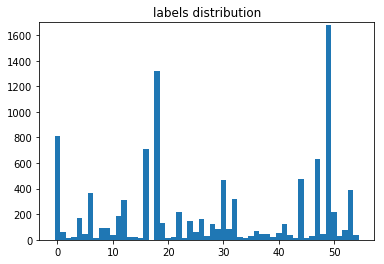

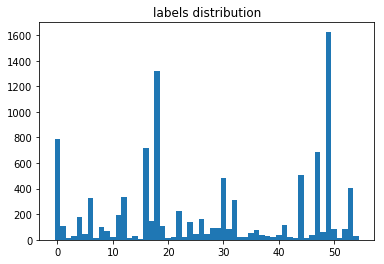

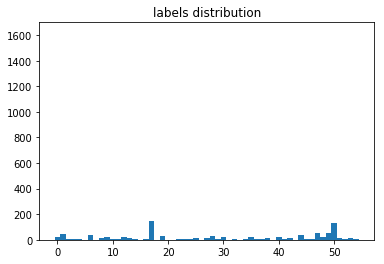

In [61]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)
_print_histogram(55, labels_test, predictions)

In [94]:
from sklearn.metrics import confusion_matrix

In [95]:
plt.spy(confusion_matrix(labels_test, predictions, range(55)), cmap = plt.cm.gist_heat_r)

NameError: name 'predictions' is not defined